In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

# Actor-Critic Methods

In REINFORCE with baseline, the learned state-value function estimates the value ofthe only thefirststate of each state transition. This estimate sets a baseline for thesubsequent return, but is made prior to the transition’s action and thus cannot be usedto assess that action. In actor–critic methods, on the other hand, the state-value functionis applied also to thesecondstate of the transition. The estimated value of the secondstate, when discounted and added to the reward, constitutes the one-step return,$G_{t:t+1}$ which is a useful estimate of the actual return and thusisa way of assessing the action.

When the state-value function is used to assess actions in this way it is called acritic,and the overall policy-gradient method is termed anactor–criticmethod. Note that thebias in the gradient estimate is not due to bootstrapping as such; the actor would bebiased even if the critic was learned by a Monte Carlo method.

## One-step Actor-critic

One-step actor–critic methods replace the full return of with the one-step return (and use a learned state-value function as the baseline)as follows

$$
\begin{equation}
\pmb\theta_{t+1}=\pmb\theta_t +\alpha(G_{t:t+1}-\hat{\nu}(S_t,\pmb{w})\frac{\nabla\pi(A_t|S_t,\pmb\theta)}{\pi(A_t|S_t,\pmb\theta)}
\end{equation}
$$

$$
\pmb\theta_{t+1}=\pmb\theta_t +\alpha(R_{t+1}\gamma\hat{\nu}(S_{t+1},\pmb{w})-\hat{\nu}(S_t,\pmb{w})\frac{\nabla\pi(A_t|S_t,\pmb\theta)}{\pi(A_t|S_t,\pmb\theta)}
$$

The main appeal of one-stepmethods is that they are fully online and incremental, yet avoid the complexities ofeligibility traces. They are a special case of the eligibility trace methods, but easierto understand

One step pseudo code:

<img src="static/img/ac_1_step.png" >

## Eligibility Traces Actor- Critic

The generalizations to the forward view ofn-step methods and then to a $\lambda$-return algorithm are straightforward. The one-step return in (1) is merely replaced by $G_{t:t+1}$ or $G{t}^{\lambda}$respectively. 
The backward view of the $\lambda$-return algorithm is also straightforward,using separate eligibility traces for the actor and critic. Pseudocode for the complete algorithm is given in the box below

<img src="static/img/ac_l_return.png" >

In [2]:
from lib.Environment_refactored import DeepTradingEnvironment, LinearAgent,DeepAgent,DeepAgentPytorch
import datetime
import numpy as np

In [3]:

out_reward_window=datetime.timedelta(days=7)
# parameters related to the transformation of data, this parameters govern an step before the algorithm
meta_parameters = {"in_bars_count": 30,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "asset_names":["asset_1","asset_2"],
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001,
                        }
print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)


assets_simulation_details={"asset_1":{"method":"GBM","sigma":.01,"mean":.02},
                    "asset_2":{"method":"GBM","sigma":.03,"mean":.18}}

env=DeepTradingEnvironment.build_environment_from_simulated_assets(assets_simulation_details=assets_simulation_details,
                                                                     data_hash="simulation_gbm",
                                                                     meta_parameters=meta_parameters,
                                                                     objective_parameters=objective_parameters)

===Meta Parameters===
{'in_bars_count': 30, 'out_reward_window': datetime.timedelta(days=7), 'state_type': 'in_window_out_window', 'asset_names': ['asset_1', 'asset_2'], 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}


In [4]:

cov=np.array([[assets_simulation_details["asset_1"]["sigma"]**2,0],[0,assets_simulation_details["asset_2"]["sigma"]**2]])
mus=np.array([assets_simulation_details["asset_1"]["mean"],assets_simulation_details["asset_2"]["mean"]])

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
ef = EfficientFrontier(mus, cov)
# weights = ef.max_sharpe(risk_free_rate=0)
weights = ef.min_volatility()

x=np.array(list(weights.values())).reshape(-1,1)
p_vol=np.sqrt(np.matmul(np.matmul(x.T,cov),x))
p_sharpe=np.matmul(x.T,mus)/p_vol



  3%|▎         | 200/6000 [00:21<10:24,  9.28it/s]

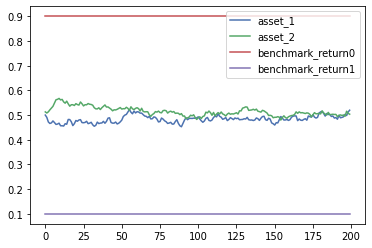

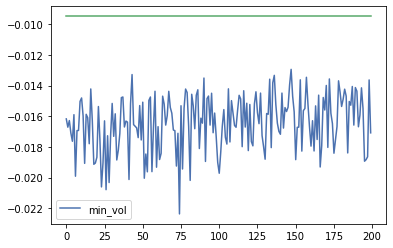

  7%|▋         | 400/6000 [00:42<10:08,  9.21it/s]

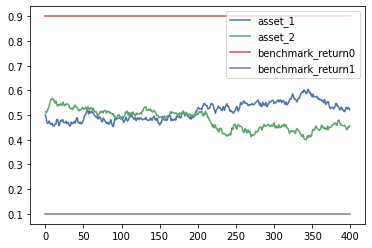

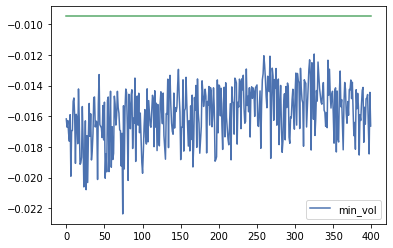

 10%|█         | 600/6000 [01:04<10:09,  8.86it/s]

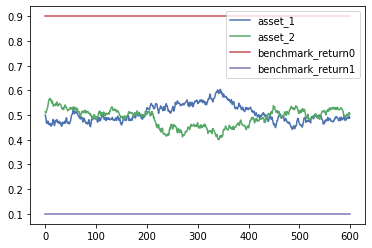

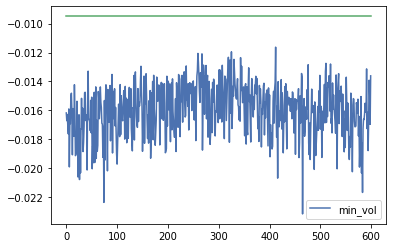

 13%|█▎        | 800/6000 [01:25<09:31,  9.10it/s]

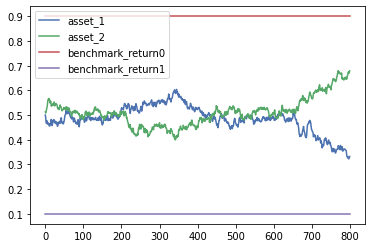

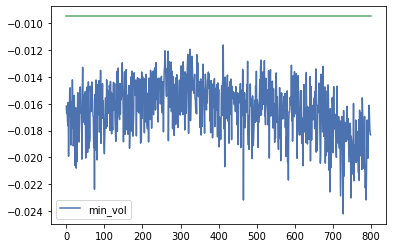

 17%|█▋        | 1000/6000 [01:47<08:55,  9.34it/s]

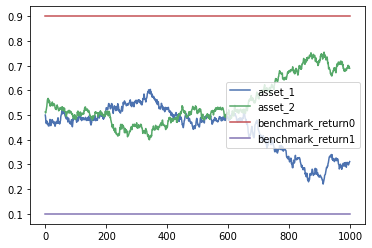

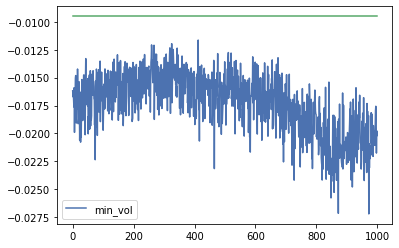

 20%|██        | 1200/6000 [02:09<08:21,  9.57it/s]

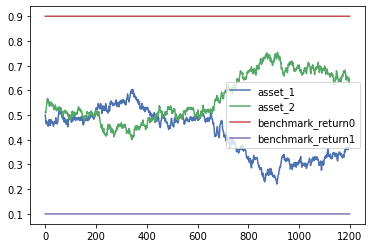

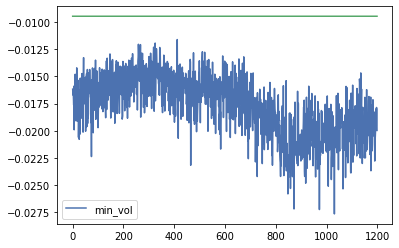

 23%|██▎       | 1400/6000 [02:30<08:15,  9.28it/s]

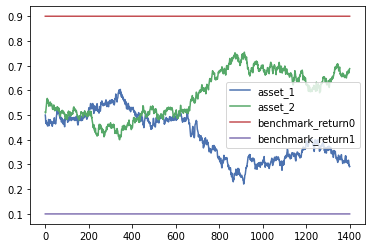

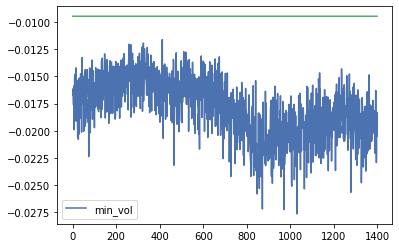

 27%|██▋       | 1600/6000 [02:51<07:27,  9.83it/s]

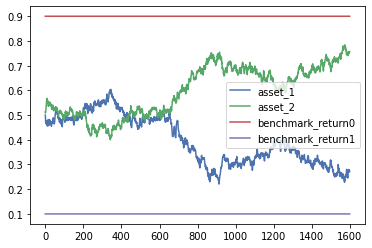

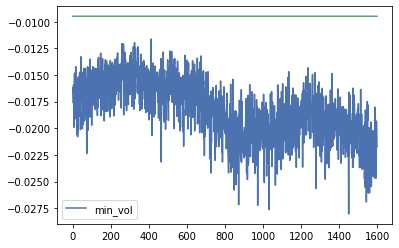

 30%|███       | 1800/6000 [03:13<07:34,  9.24it/s]

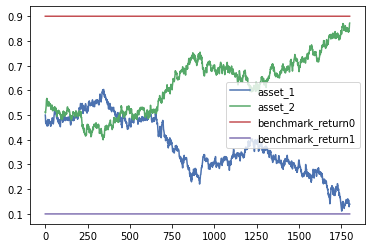

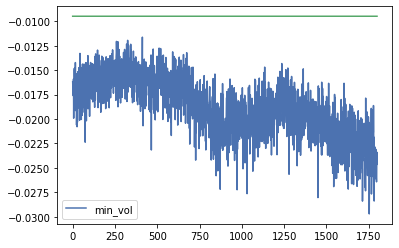

 33%|███▎      | 2000/6000 [03:34<06:46,  9.85it/s]

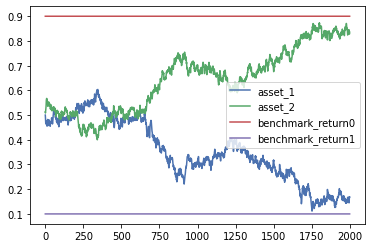

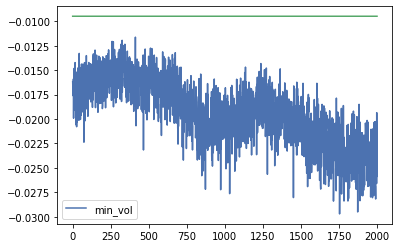

 37%|███▋      | 2200/6000 [03:56<06:30,  9.72it/s]

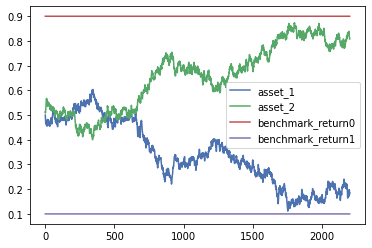

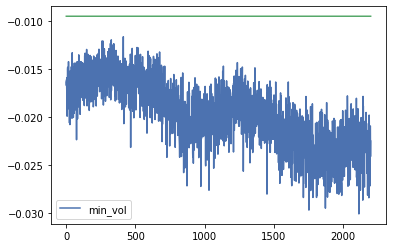

 40%|████      | 2400/6000 [04:18<06:15,  9.60it/s]

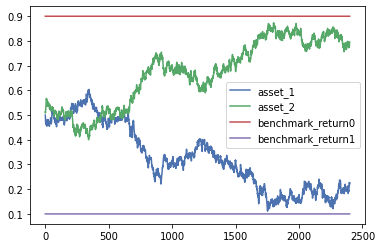

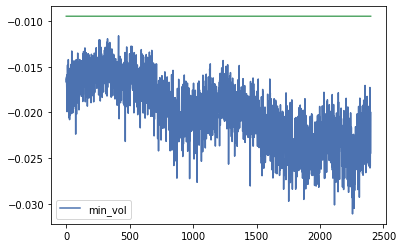

 43%|████▎     | 2600/6000 [04:39<05:58,  9.50it/s]

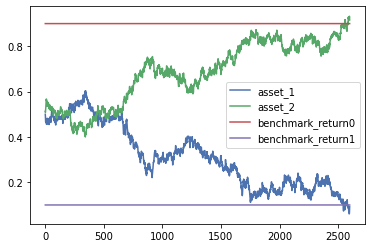

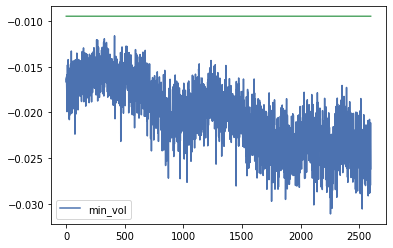

 47%|████▋     | 2800/6000 [05:00<05:39,  9.42it/s]

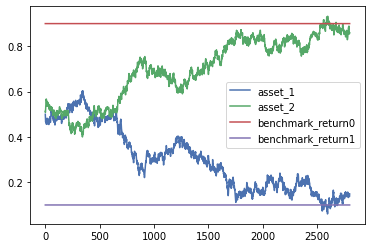

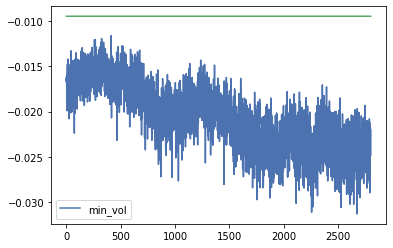

 50%|█████     | 3000/6000 [05:22<05:13,  9.57it/s]

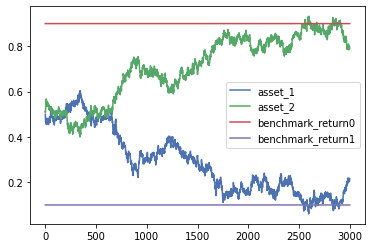

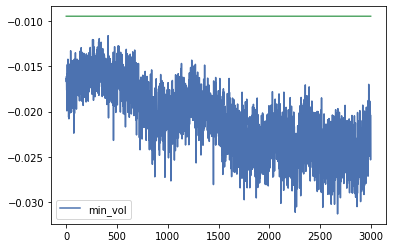

 53%|█████▎    | 3200/6000 [05:44<04:56,  9.45it/s]

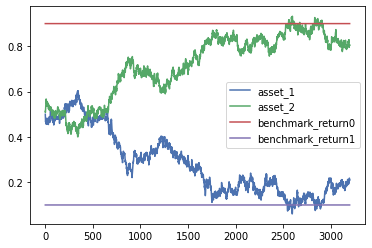

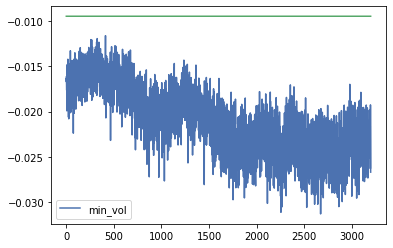

 57%|█████▋    | 3400/6000 [06:05<04:36,  9.40it/s]

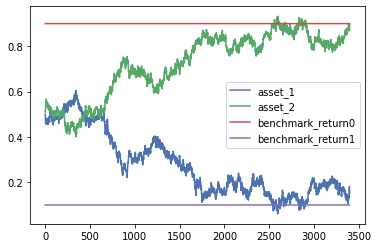

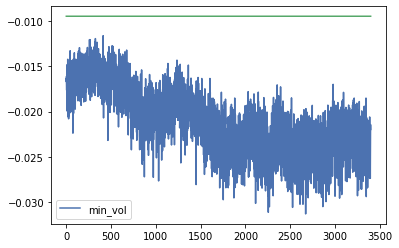

 60%|██████    | 3600/6000 [06:27<04:31,  8.85it/s]

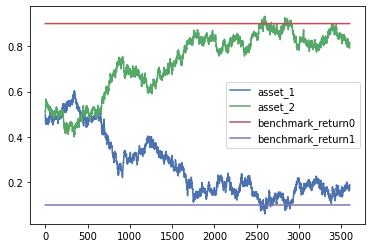

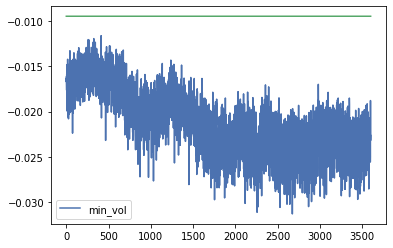

 63%|██████▎   | 3800/6000 [06:48<03:44,  9.78it/s]

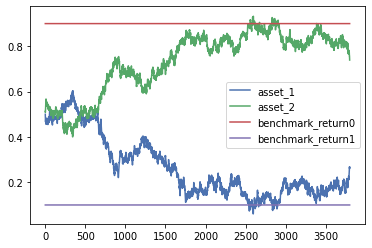

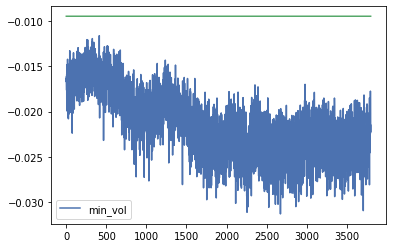

 67%|██████▋   | 4000/6000 [07:10<03:45,  8.87it/s]

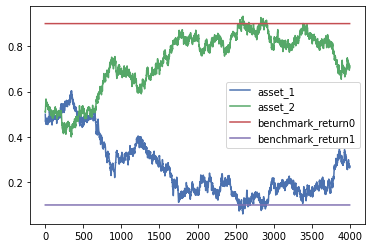

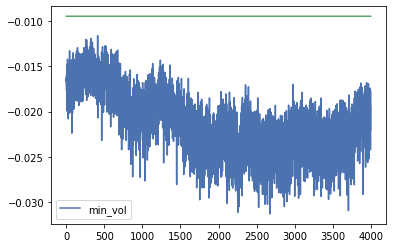

 70%|███████   | 4200/6000 [07:32<03:07,  9.60it/s]

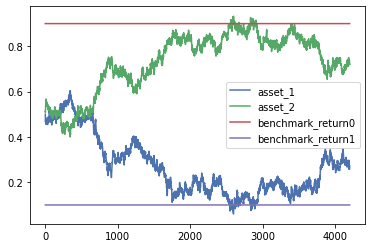

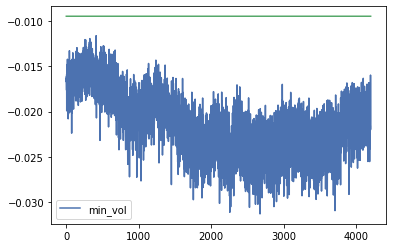

 73%|███████▎  | 4400/6000 [07:53<02:43,  9.76it/s]

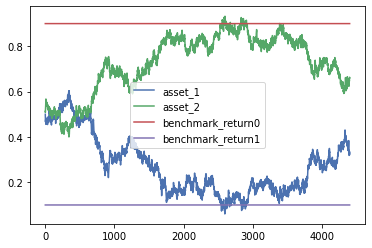

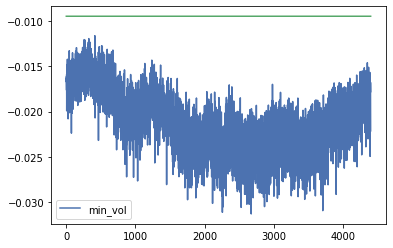

 77%|███████▋  | 4600/6000 [08:15<02:24,  9.69it/s]

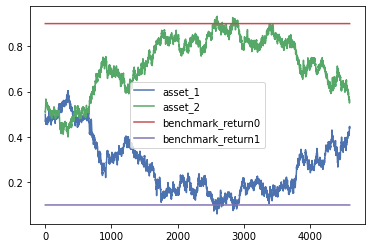

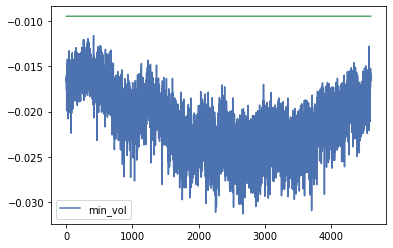

 80%|████████  | 4800/6000 [08:36<02:06,  9.47it/s]

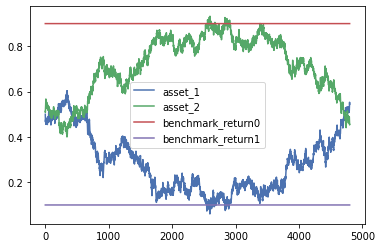

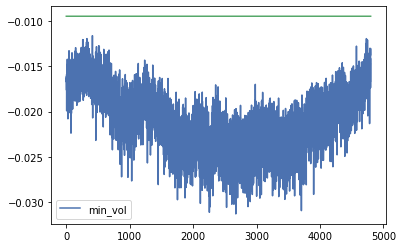

 83%|████████▎ | 5000/6000 [08:58<01:42,  9.78it/s]

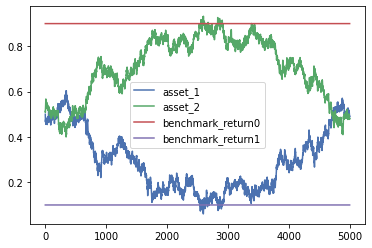

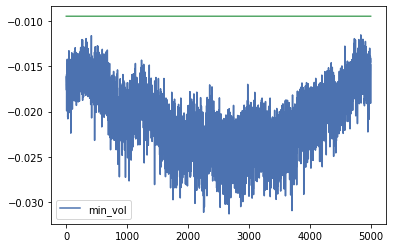

 87%|████████▋ | 5200/6000 [09:19<01:22,  9.71it/s]

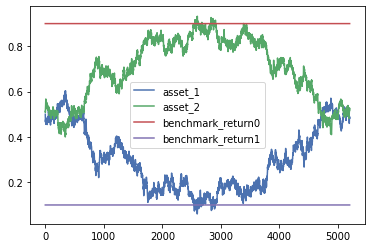

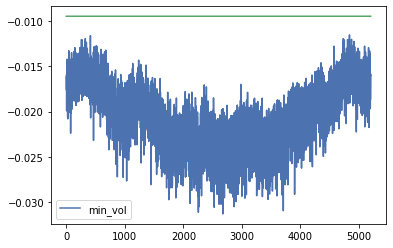

 90%|█████████ | 5400/6000 [09:41<01:05,  9.20it/s]

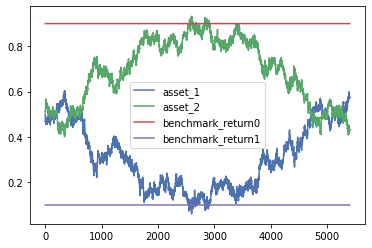

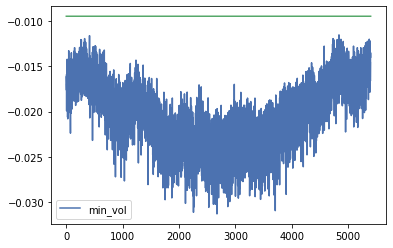

 93%|█████████▎| 5600/6000 [10:03<00:43,  9.27it/s]

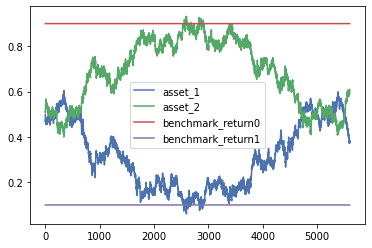

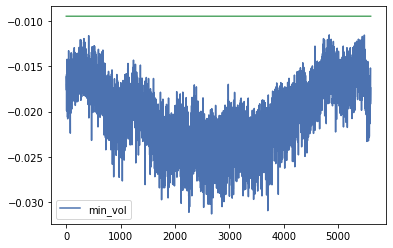

 97%|█████████▋| 5800/6000 [10:24<00:21,  9.39it/s]

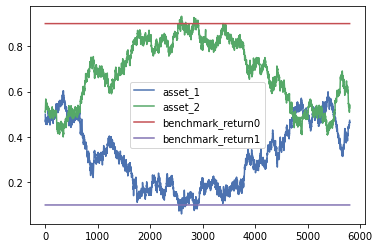

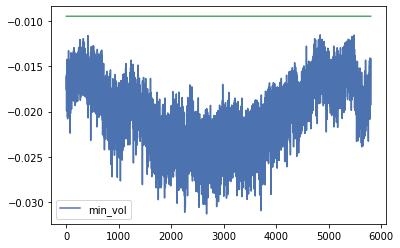

100%|██████████| 6000/6000 [10:46<00:00,  9.48it/s]

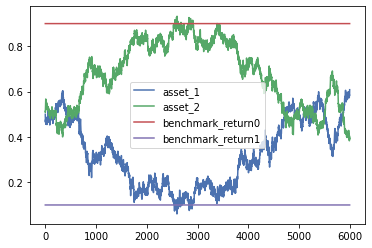

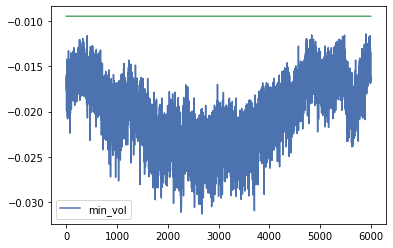

[asset_1    0.500034
 asset_2    0.512900
 dtype: float64,
 asset_1    0.490603
 asset_2    0.508361
 dtype: float64,
 asset_1    0.472079
 asset_2    0.513230
 dtype: float64,
 asset_1    0.466107
 asset_2    0.521216
 dtype: float64,
 asset_1    0.468363
 asset_2    0.528051
 dtype: float64,
 asset_1    0.47627
 asset_2    0.53529
 dtype: float64,
 asset_1    0.469750
 asset_2    0.548371
 dtype: float64,
 asset_1    0.462247
 asset_2    0.562023
 dtype: float64,
 asset_1    0.463680
 asset_2    0.563733
 dtype: float64,
 asset_1    0.467281
 asset_2    0.567473
 dtype: float64,
 asset_1    0.456657
 asset_2    0.561267
 dtype: float64,
 asset_1    0.456738
 asset_2    0.563498
 dtype: float64,
 asset_1    0.455642
 asset_2    0.553388
 dtype: float64,
 asset_1    0.465101
 asset_2    0.548126
 dtype: float64,
 asset_1    0.462905
 asset_2    0.556333
 dtype: float64,
 asset_1    0.482241
 asset_2    0.545457
 dtype: float64,
 asset_1    0.481940
 asset_2    0.536039
 dtype: float64,

In [5]:

linear_agent=LinearAgent(environment=env,out_reward_window_td=out_reward_window,
                         reward_function="min_vol",sample_observations=32)

linear_agent.set_plot_weights(weights=np.array(list(weights.values())),
                              benchmark_G=-p_vol.ravel()[0])

linear_agent.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=6000)


  3%|▎         | 200/6000 [00:23<11:08,  8.68it/s]

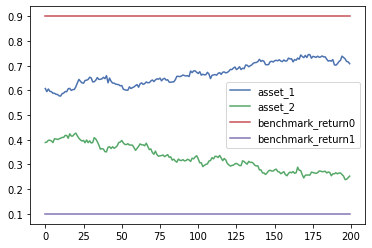

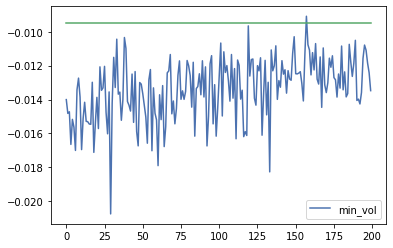


  7%|▋         | 400/6000 [00:47<10:58,  8.50it/s]

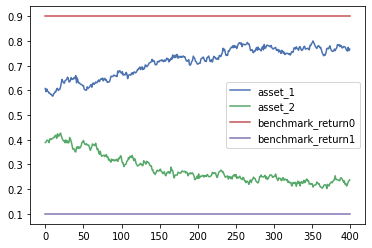

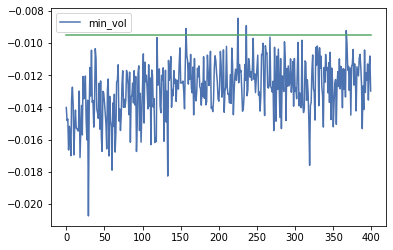


 10%|█         | 600/6000 [01:11<10:36,  8.48it/s]

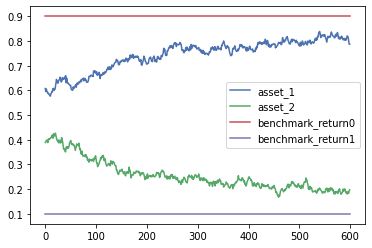

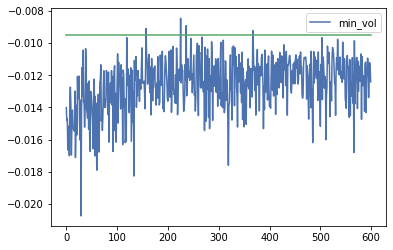


 13%|█▎        | 800/6000 [01:34<10:01,  8.65it/s]

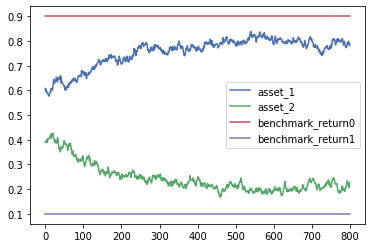

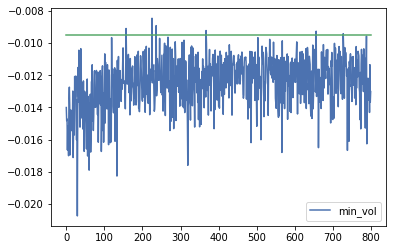


 17%|█▋        | 1000/6000 [01:58<10:18,  8.08it/s]

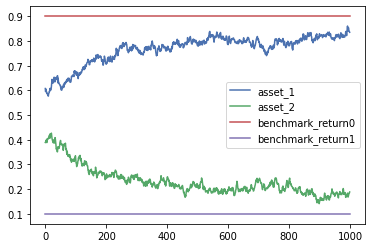

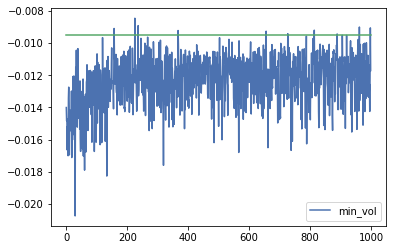


 20%|██        | 1200/6000 [02:22<09:12,  8.69it/s]

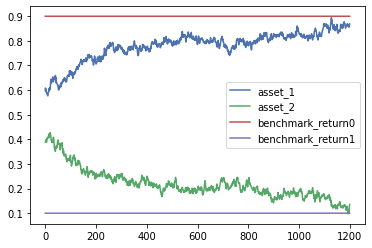

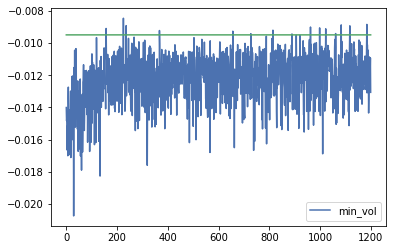


 23%|██▎       | 1400/6000 [02:46<08:49,  8.69it/s]

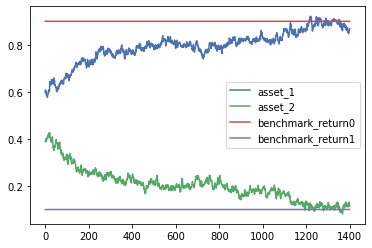

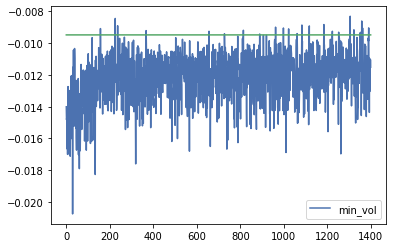


 27%|██▋       | 1600/6000 [03:10<08:38,  8.49it/s]

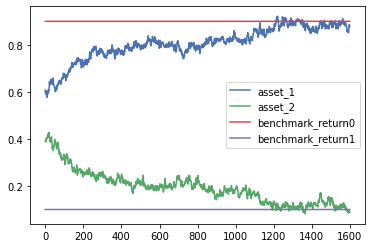

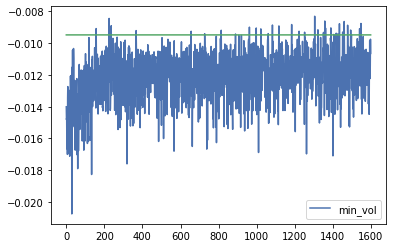


 30%|███       | 1800/6000 [03:33<08:22,  8.36it/s]

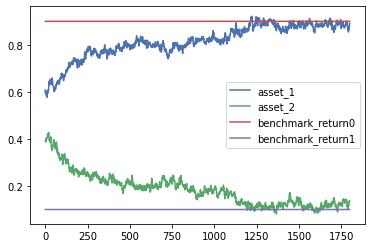

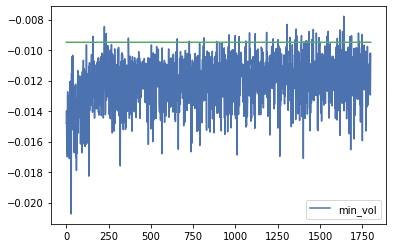


 33%|███▎      | 2000/6000 [03:57<07:44,  8.61it/s]

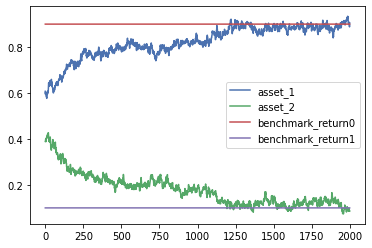

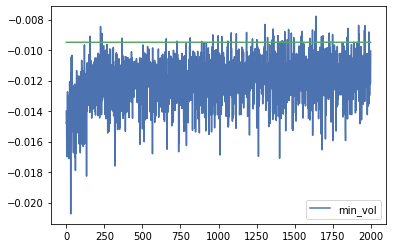


 37%|███▋      | 2200/6000 [04:21<07:25,  8.53it/s]

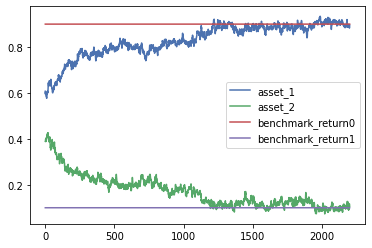

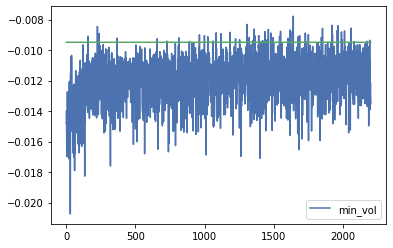


 40%|████      | 2400/6000 [04:45<07:03,  8.50it/s]

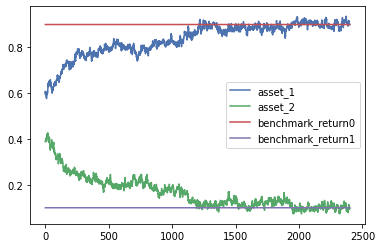

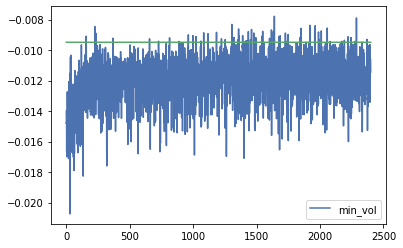


 43%|████▎     | 2600/6000 [05:09<07:09,  7.92it/s]

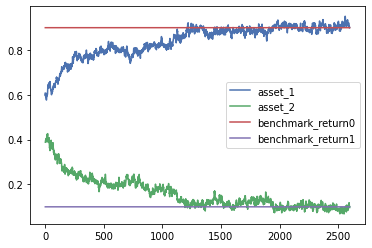

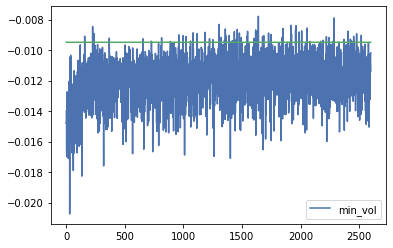


 47%|████▋     | 2800/6000 [05:33<06:09,  8.67it/s]

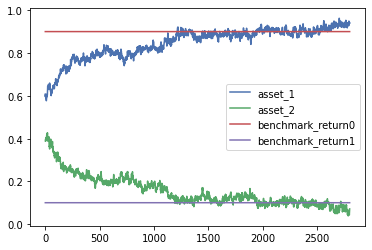

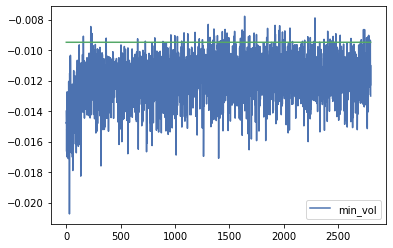


 50%|█████     | 3000/6000 [05:57<05:39,  8.84it/s]

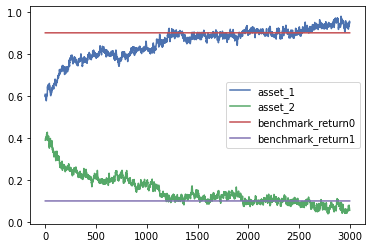

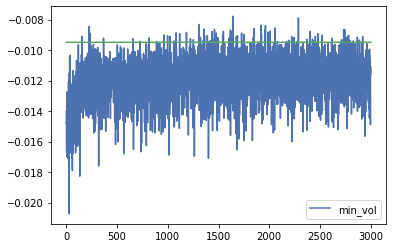


 53%|█████▎    | 3200/6000 [06:21<05:42,  8.17it/s]

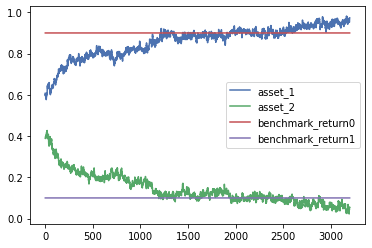

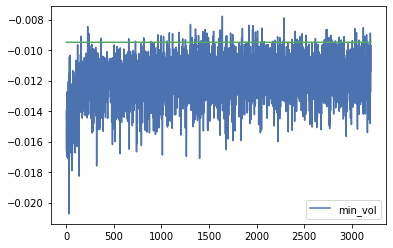


 57%|█████▋    | 3400/6000 [06:44<05:00,  8.64it/s]

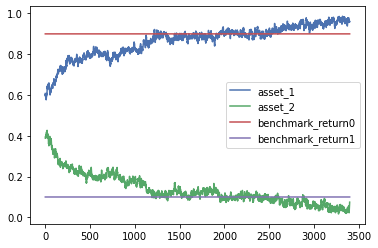

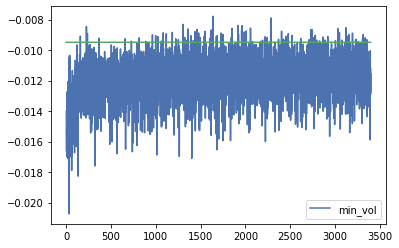


 60%|██████    | 3600/6000 [07:08<04:47,  8.36it/s]

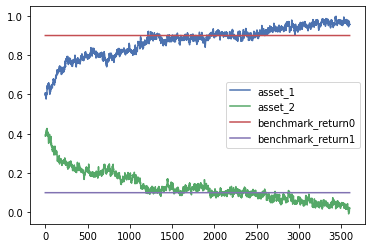

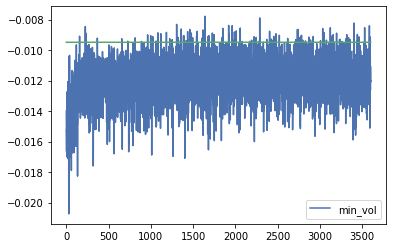


 63%|██████▎   | 3800/6000 [07:32<04:10,  8.77it/s]

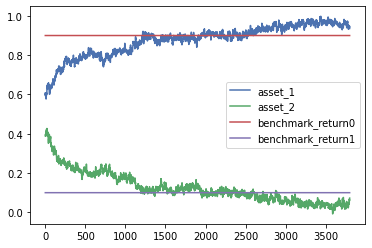

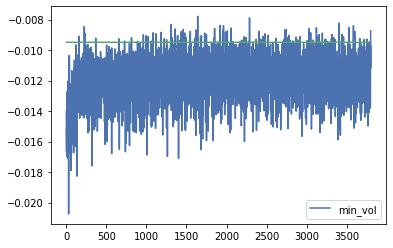


 67%|██████▋   | 4000/6000 [07:56<03:48,  8.75it/s]

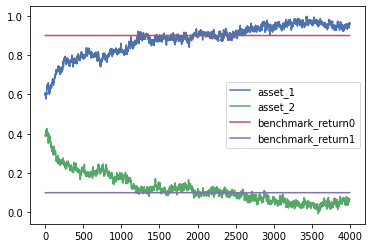

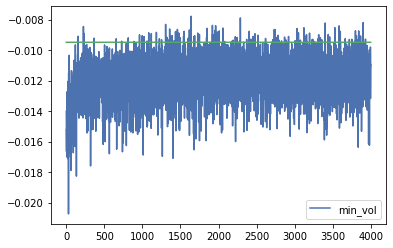


 70%|███████   | 4200/6000 [08:20<03:34,  8.40it/s]

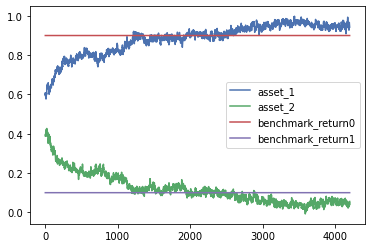

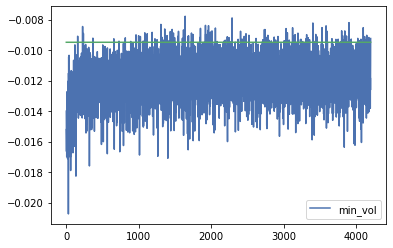


 73%|███████▎  | 4400/6000 [08:44<03:02,  8.76it/s]

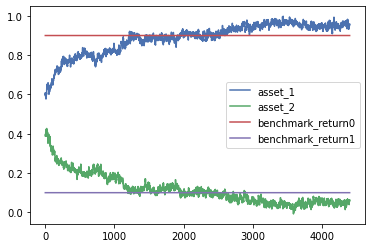

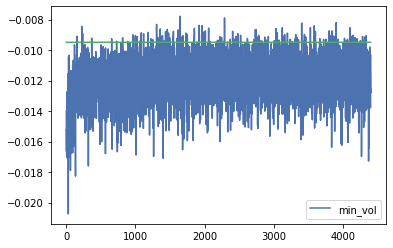


 77%|███████▋  | 4600/6000 [09:08<02:45,  8.48it/s]

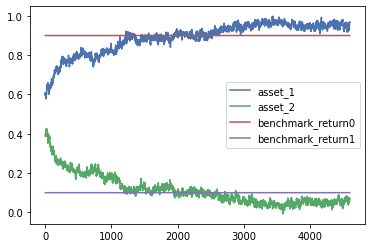

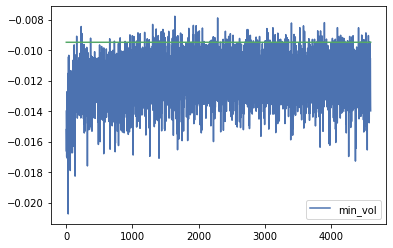


 80%|████████  | 4800/6000 [09:32<02:19,  8.61it/s]

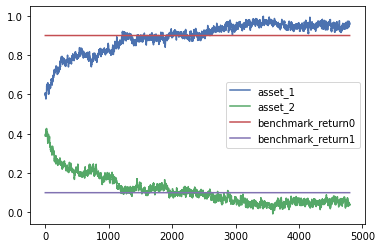

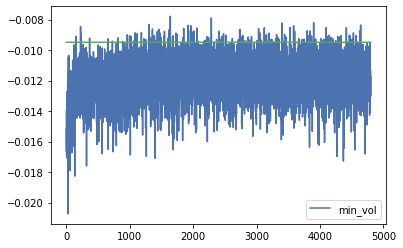


 83%|████████▎ | 5000/6000 [09:55<02:02,  8.16it/s]

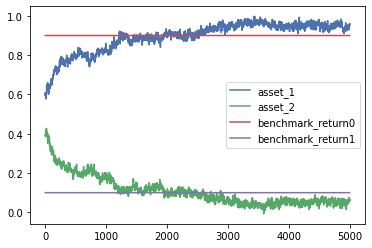

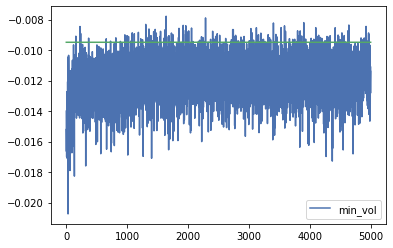


 87%|████████▋ | 5200/6000 [10:19<01:31,  8.77it/s]

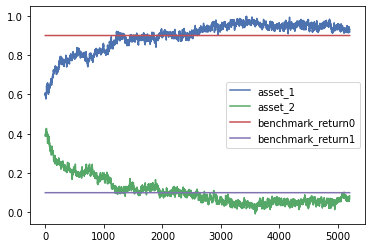

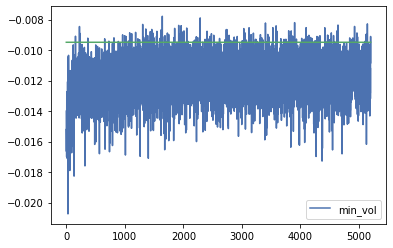


 90%|█████████ | 5400/6000 [10:44<01:09,  8.68it/s]

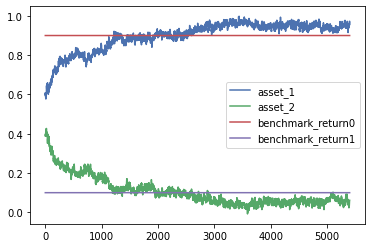

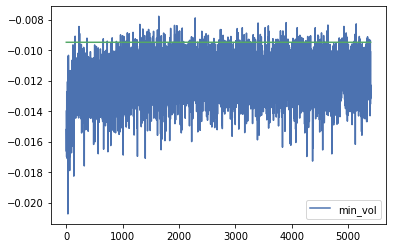


 93%|█████████▎| 5600/6000 [11:07<00:46,  8.65it/s]

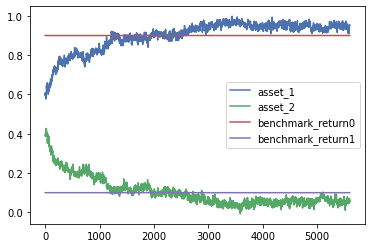

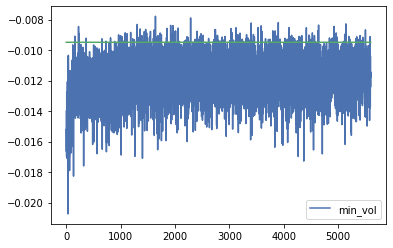


 97%|█████████▋| 5800/6000 [11:31<00:24,  8.30it/s]

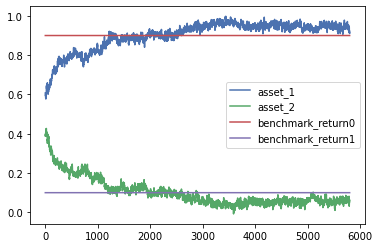

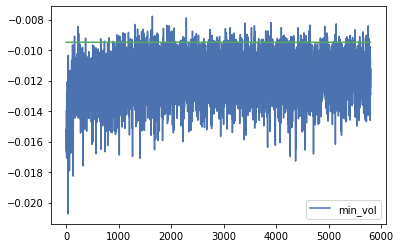


100%|██████████| 6000/6000 [11:55<00:00,  8.24it/s]

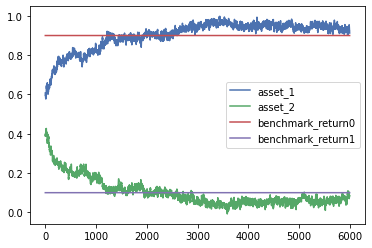

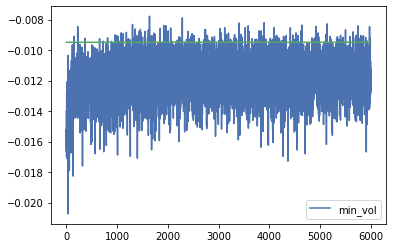

[asset_1    0.607505
 asset_2    0.389032
 dtype: float64,
 asset_1    0.594893
 asset_2    0.390835
 dtype: float64,
 asset_1    0.605609
 asset_2    0.397893
 dtype: float64,
 asset_1    0.595990
 asset_2    0.398342
 dtype: float64,
 asset_1    0.594714
 asset_2    0.395186
 dtype: float64,
 asset_1    0.588266
 asset_2    0.388637
 dtype: float64,
 asset_1    0.588402
 asset_2    0.404009
 dtype: float64,
 asset_1    0.584006
 asset_2    0.403372
 dtype: float64,
 asset_1    0.583449
 asset_2    0.401238
 dtype: float64,
 asset_1    0.578016
 asset_2    0.403587
 dtype: float64,
 asset_1    0.576770
 asset_2    0.406432
 dtype: float64,
 asset_1    0.586750
 asset_2    0.409546
 dtype: float64,
 asset_1    0.588847
 asset_2    0.409666
 dtype: float64,
 asset_1    0.595212
 asset_2    0.417709
 dtype: float64,
 asset_1    0.59463
 asset_2    0.41741
 dtype: float64,
 asset_1    0.606813
 asset_2    0.406247
 dtype: float64,
 asset_1    0.608034
 asset_2    0.424158
 dtype: float64,

In [6]:
linear_agent.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=6000)